In [3]:
from netCDF4 import Dataset as NetCDFFile
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
import xarray as xr
from numpy import meshgrid
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.font_manager import findfont, FontProperties
from mpl_toolkits.basemap import Basemap
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
font = findfont(FontProperties(family=['sans-serif']))
font

'/System/Library/Fonts/LucidaGrande.ttc'

In [2]:
owda = xr.open_dataset('owda_hd_fix_500.nc').pdsi.transpose('time','lon','lat')
xx,yy=meshgrid(owda.lat,owda.lon)
owda2 = np.array(owda.sel(time=slice(1300,2012)))
for x in range(0,114):
    for y in range(0,88):
        if owda2[0,x,y] == np.nan:
            owda2[:,x,y] = np.nan
        else:
            continue


In [3]:
from eofs.standard import Eof
coslat = np.expand_dims(np.expand_dims(np.cos(np.radians(owda.lat)),axis=0),axis=1)
wght1 = np.sqrt(np.tile(coslat,[711,114,1]))

solver={};pc={};eof={};eigen={};variance={};
solver = Eof(owda2,weights = wght1)
pc = solver.pcs(npcs=50,pcscaling=1)
eof = solver.eofs(eofscaling=2,neofs=5)
eigen = solver.eigenvalues()
variance = solver.varianceFraction()
print(variance[0:5])


[0.14872253 0.11489574 0.07411246 0.06099383 0.05270824]


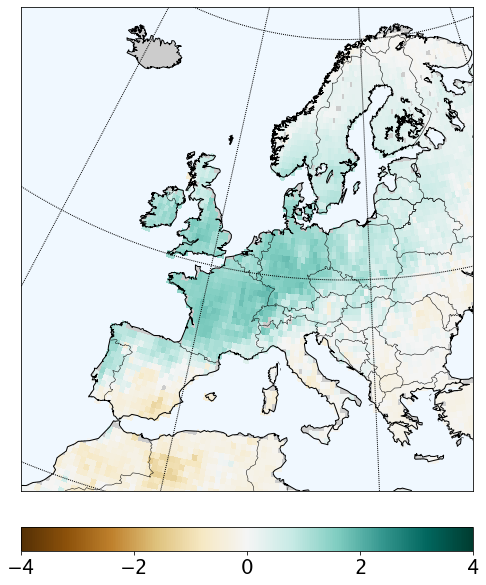

In [6]:
data=np.squeeze(eof[0,:,:])
    
plt.figure(figsize=(15,10))
#plt.title('EOF1',size=20)
map = Basemap(projection='aea',lat_0=49.25,lon_0=16.75,llcrnrlon=-11.75,llcrnrlat=27.75,urcrnrlon=44.75,urcrnrlat=70.75,resolution='l')

map.drawcoastlines()
map.drawcountries()
map.drawlsmask(ocean_color='aliceblue')
parallels = np.arange(30,90,20)
meridians = np.arange(-20,60,20)
map.drawparallels(parallels)
map.drawmeridians(meridians)
map.pcolormesh(yy-0.5,xx-0.5,np.array(data),cmap='BrBG',latlon=True, vmin=-4, vmax=4)
cbar = map.colorbar(location='bottom',pad=0.5)
cbar.ax.tick_params(labelsize=20)

#write python dict to a file
import pickle
output = open('EOF1.pkl','wb')
pickle.dump(data,output)
output.close()


In [7]:
pc1 = pc[:,0]; pc1_s = np.array(pd.DataFrame(data=pc1).rolling(3,min_periods=3).mean())

Europe3 = np.load('EuropePDSI3.npy')#EuropePDSI is calculted from Tables1_2
Europe3 = (Europe3 - np.nanmean(Europe3))/np.nanstd(Europe3)#normalize Europe PDSI

#correlate PC1 and EuropePDSI
np.corrcoef(np.squeeze(pc1_s[2::]),np.squeeze(Europe3[2::]))

array([[1.        , 0.94799997],
       [0.94799997, 1.        ]])

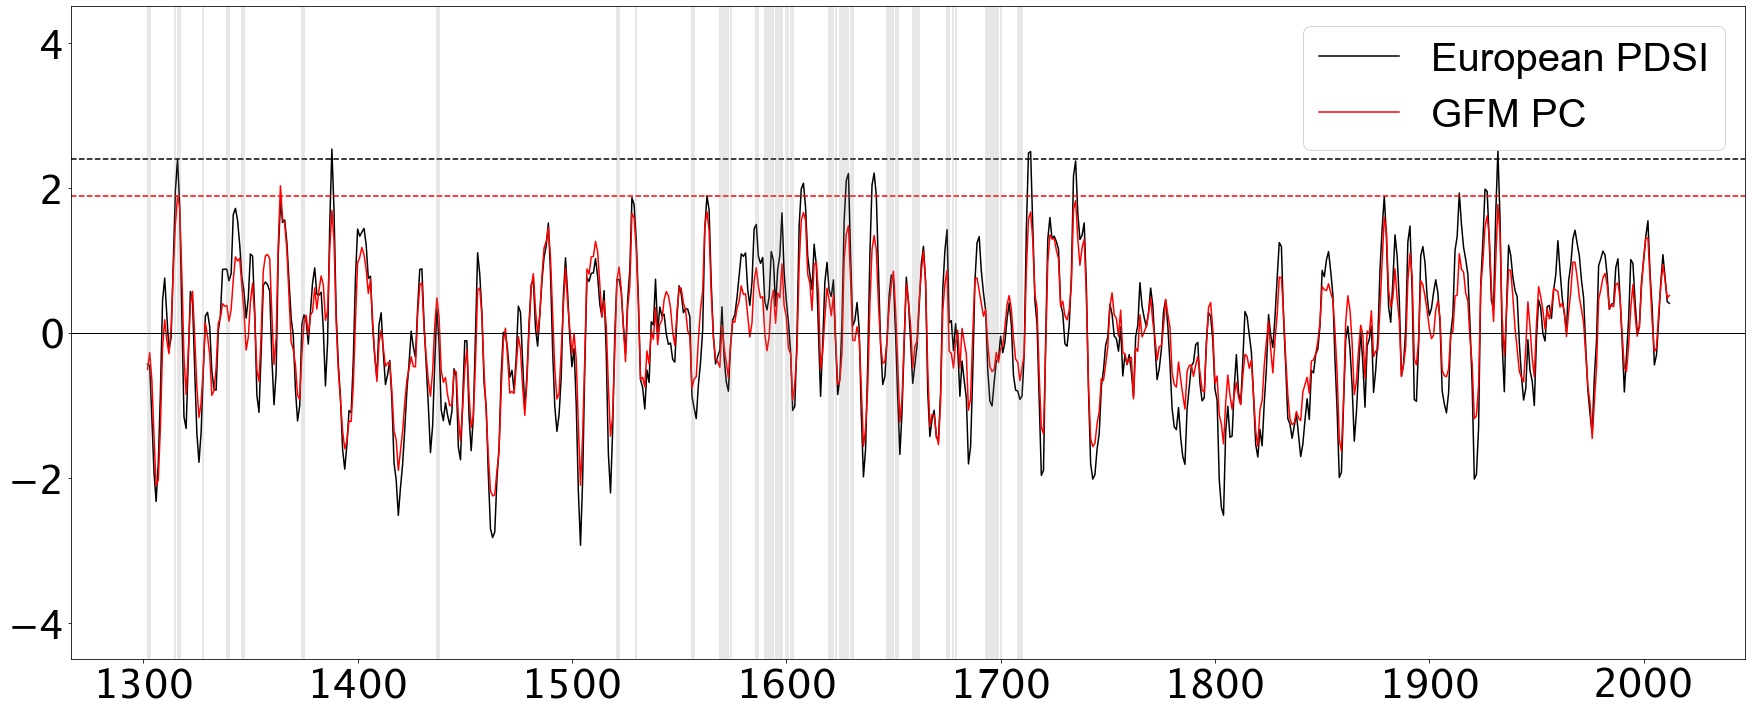

In [8]:
font = findfont(FontProperties(family=['sans-serif']))

plt.figure(figsize=(30,12))

#shift by one to center 3-year window to middle year
line2 = plt.plot(Europe3,color='black',label="European PDSI");plt.setp(line2,linewidth = 1.5);
line1 = plt.plot(pc1_s,color='red',label="GFM PC");plt.setp(line1,linewidth = 1.5);
plt.legend(loc=1,prop={'size':40, 'family':'Arial'})


plt.ylim((-4.5,4.5))

xval=[1300,1400,1500,1600,1700,1800,1900,2000]
x = [0,100,200,300,400,500,600,700]
plt.xticks(x,xval);

plt.axhline(y=0,linewidth=1,color='black')
plt.axhline(y=pc1_s[16],color='red',linestyle='--')
plt.axhline(y=Europe3[16],color='black',linestyle='--')


plt.tick_params(axis='both', which='major', labelsize=40)


#highlight 1300 - 1710 Europe famines
years = {}
years['10'] = np.array([1302,1303,1315,1316,1317,1328,1339,1340,1346,1347,1374,1375,1437,1438,1521,1522,1530,1556,
                        1557,1569,1570,1571,1572,1573,1574,1586,1587,1590,1591,1592,1593,1594,1595,1596,1597,1598,
                        1600,1601,1602,1603,1620,1621,1622,1623,1625,1626,1627,1628,1629,1630,1631,1647,1648,1649,
                        1650,1651,1652,1659,1660,1661,1662,1675,1676,1678,1679,1693,1694,1695,1696,1697,1698,1699,
                        1700,1708,1709,1710]) 
for i in range(0,len(years['10'])):
    plt.axvline(x=years['10'][i]-1300, alpha=0.25, color='gray')


In [11]:
Europe = np.load('EuropePDSI.npy')#EuropePDSI is calculted from Tables1_2
wet = [x for x,y in enumerate(Europe) if y > 1];
dry = [x for x,y in enumerate(Europe) if y < -1];

np.shape(wet)

(58,)

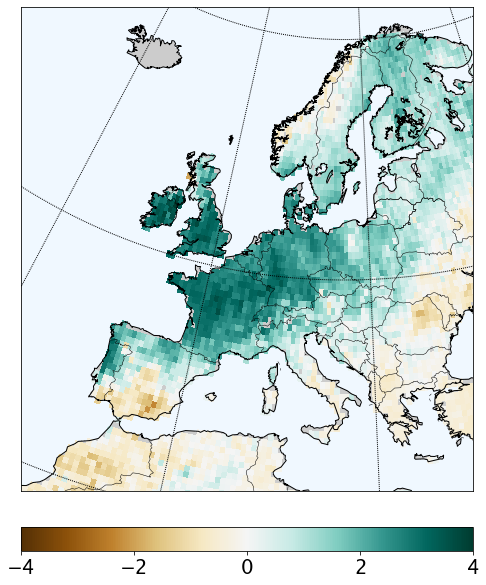

In [12]:
owda = xr.open_dataset('owda_hd_fix_500.nc').pdsi
data=np.squeeze(np.nanmean(owda.sel(time=slice(1300,2012))[:,:,wet],axis=2))#replace wet with dry for dry composite
xx,yy=meshgrid(owda.lat,owda.lon)

   
plt.figure(figsize=(15,10))
map = Basemap(projection='aea',lat_0=49.25,lon_0=16.75,llcrnrlon=-11.75,llcrnrlat=27.75,urcrnrlon=44.75,urcrnrlat=70.75,resolution='l')
map.drawcoastlines()
map.drawcountries()
map.drawlsmask(ocean_color='aliceblue')
parallels = np.arange(30,90,20)
meridians = np.arange(-20,60,20)
map.drawparallels(parallels)
map.drawmeridians(meridians)
map.pcolormesh(yy-0.5,xx-0.5,np.array(data),cmap='BrBG',latlon=True, vmin=-4, vmax=4)
cbar = map.colorbar(location='bottom',pad=0.5)
cbar.ax.tick_params(labelsize=20)

#write python dict to a file
import pickle
output = open('wet.pkl','wb')#replace wet with dry for dry composite
pickle.dump(data,output)
output.close()

## Scatterplots

In [28]:
import reverse_geocode
#Country Masks
UK_mask = np.zeros((114,88));France_mask = np.zeros((114,88));Germany_mask = np.zeros((114,88));
Switzerland_mask = np.zeros((114,88));Austria_mask = np.zeros((114,88));Belgium_mask = np.zeros((114,88));
Netherlands_mask = np.zeros((114,88));Luxembourg_mask = np.zeros((114,88));Italy_mask = np.zeros((114,88));
Europe_mask = np.zeros((114,88)); Europe_mask[:,:] = np.nan

for x in range(0,114):
    for y in range(0,88):
        coordinates = (owda.lat[y], owda.lon[x]), 
        if 'United Kingdom' in str(reverse_geocode.search(coordinates)):
            UK_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            UK_mask[x,y] = np.nan
            
        if 'France' in str(reverse_geocode.search(coordinates)):
            France_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            France_mask[x,y] = np.nan

        if 'Germany' in str(reverse_geocode.search(coordinates)):
            Germany_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            Germany_mask[x,y] = np.nan

        if 'Switzerland' in str(reverse_geocode.search(coordinates)):
            Switzerland_mask[x,y] = 1
        else:
            Switzerland_mask[x,y] = np.nan

        if 'Austria' in str(reverse_geocode.search(coordinates)):
            Austria_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            Austria_mask[x,y] = np.nan

        if 'Belgium' in str(reverse_geocode.search(coordinates)):
            Belgium_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            Belgium_mask[x,y] = np.nan
            
        if 'Netherlands' in str(reverse_geocode.search(coordinates)):
            Netherlands_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            Netherlands_mask[x,y] = np.nan

        if 'Luxembourg' in str(reverse_geocode.search(coordinates)):
            Luxembourg_mask[x,y] = 1
            Europe_mask[x,y] = 1
        else:
            Luxembourg_mask[x,y] = np.nan
            
        if 'Italy' in str(reverse_geocode.search(coordinates)):
            Italy_mask[x,y] = 1
        else:
            Italy_mask[x,y] = np.nan

In [29]:
Europe = owda.sel(time=slice(1901,2012))*np.tile(np.expand_dims(Europe_mask,axis=0),[112,1,1])
for y in range(0,88):
    Europe[:,:,y] = Europe[:,:,y]*np.cos(np.radians(owda.lat[y]))#area-weight
Europe = np.nanmean(np.nanmean(Europe,axis=2),axis=1)
   

In [77]:
pc1 = pc[:,0]*-1; 
pc2 = pc[:,1]*-1;

Text(0, 0.5, 'PDSI')

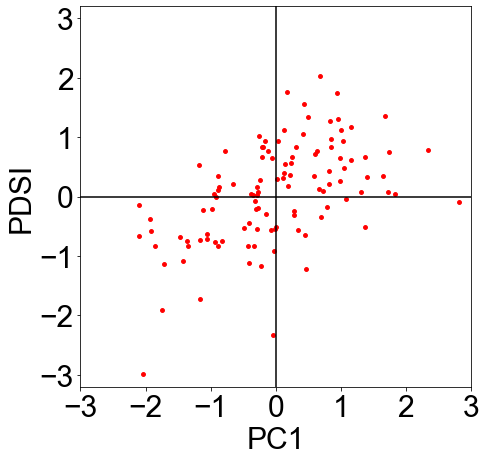

In [102]:
# Say, "the default sans-serif font is COMIC SANS"
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "Arial"


fig = plt.figure(figsize=(7,7))
x1 = pc1; y1 = Europe
plt.scatter(x1,y1,s=15,marker='o',c='red')
plt.xlim([-3,3]);plt.xticks([-3,-2,-1,0,1,2,3]) 
plt.ylim([-3.2,3.2]);plt.yticks([-3,-2,-1,0,1,2,3])

plt.plot([-5, 5],[0, 0],'k',3.5)
plt.plot([0,0],[-5,5],'k',3.5)
plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlabel('PC1',size=30)
plt.ylabel('PDSI',size=30)




Text(0, 0.5, 'PDSI')

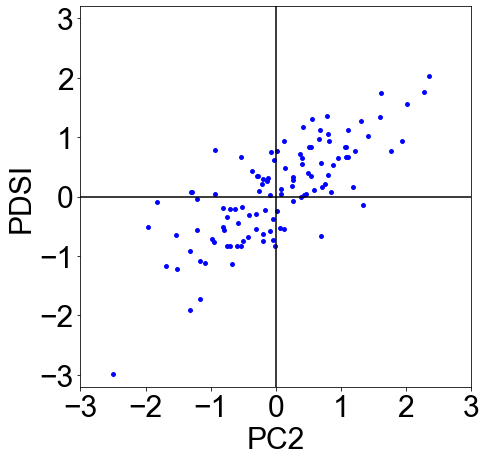

In [100]:
# Say, "the default sans-serif font is COMIC SANS"
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "Arial"


fig = plt.figure(figsize=(7,7))
x1 = pc2; y1 = Europe
plt.scatter(x1,y1,s=15,marker='o',c='blue')
plt.xlim([-3,3]);plt.xticks([-3,-2,-1,0,1,2,3]) 
plt.ylim([-3.2,3.2]);plt.yticks([-3,-2,-1,0,1,2,3])

plt.plot([-5, 5],[0, 0],'k',3.5)
plt.plot([0,0],[-5,5],'k',3.5)
plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlabel('PC2',size=30)
plt.ylabel('PDSI',size=30)

